In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt
import pandas as pd
import datetime as dt
import pickle
import os
import pickle

from functions import PositionalEncoding


In [51]:

TOR_FEATURES_PATH = "data/Combi_test/Transformer_AWS_61k_COMBI-tor_features_test.npy"
TOR_LABELS_PATH = "data/Combi_test/Transformer_AWS_61k_COMBI-tor_labels_test.npy"

VPN_FEATURES_PATH = "data/Combi_test/Transformer_AWS_61k_COMBI-vpn_features_test.npy"
VPN_LABELS_PATH = "data/Combi_test/Transformer_AWS_61k_COMBI-vpn_labels_test.npy"

MODEL_PATH = "models/Transformer_AWS_61k_COMBI_model_Datetime_2023_04_25__13_25_06__loss_0.47210320830345154_acc_0.8665324449539185.h5"

BINIRISER_PATH = "encoders/Transformer_AWS_61k_COMBIbinarizer.pkl"

MODEL_NAME = "Transformer_AWS_61k_COMBI"

DATA_NAME = "AWS_61k_COMBI"

SITES_PATH = "VPN_client_scripts/urls/top_100_v2.csv"

SEED = 42

In [3]:
class CustomAdam(tf.keras.optimizers.Adam):
    def __init__(self, weight_decay, **kwargs):
        super(CustomAdam, self).__init__(**kwargs)

    def get_config(self):
        base_config = super(CustomAdam, self).get_config()
        return {**base_config}


In [9]:
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={'PositionalEncoding': PositionalEncoding, 'CustomAdam': CustomAdam},
    compile=False
)



In [11]:
learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 150, 2)]     0         
                                                                 
 transformer_encoder (Functi  (None, 200, 128)         8742528   
 onal)                                                           
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 101)               13029     
                                                                 
Total params: 8,755,557
Trainable params: 8,755,557
Non-trainable params: 0
_________________________________________________________________


In [52]:
with open(VPN_FEATURES_PATH, 'rb') as f:
    vpn_features_test = np.load(f)
  
with open(VPN_LABELS_PATH, 'rb') as f:
    vpn_labels_test = np.load(f)
  

with open(TOR_FEATURES_PATH, 'rb') as f:
    tor_features_test = np.load(f)
  
with open(TOR_LABELS_PATH, 'rb') as f:
    tor_labels_test = np.load(f)



In [32]:
def load_label_binarizer(path):
    with open(path,  'rb') as file:
        encoder = pickle.load(file)
    return encoder


In [33]:
label_binariser = load_label_binarizer(BINIRISER_PATH)

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [36]:
tor_y_true = np.argmax(tor_labels_test, axis=1)
tor_unique_y = np.unique(tor_y_true)

In [53]:
vpn_y_true = np.argmax(vpn_labels_test, axis=1)
vpn_unique_y = np.unique(vpn_y_true)

In [57]:
def plot_results(model, features_test, labels_test):
    fig, ax = plt.subplots(figsize=(30, 30))
    y_true = np.argmax(labels_test, axis=1)
    predictions =  np.argmax(model.predict(features_test), axis=1)
    cm = confusion_matrix(y_true, predictions, normalize='true')
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[label_binariser.classes_[x] for x in range(vpn_unique_y.min(), len(vpn_unique_y))]
        )
    disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
    plt.show()
    print(classification_report(y_true, predictions))
 

In [54]:
print(vpn_features_test.shape)
print(vpn_labels_test.shape)

(8431, 200, 150, 2)
(8431, 101)


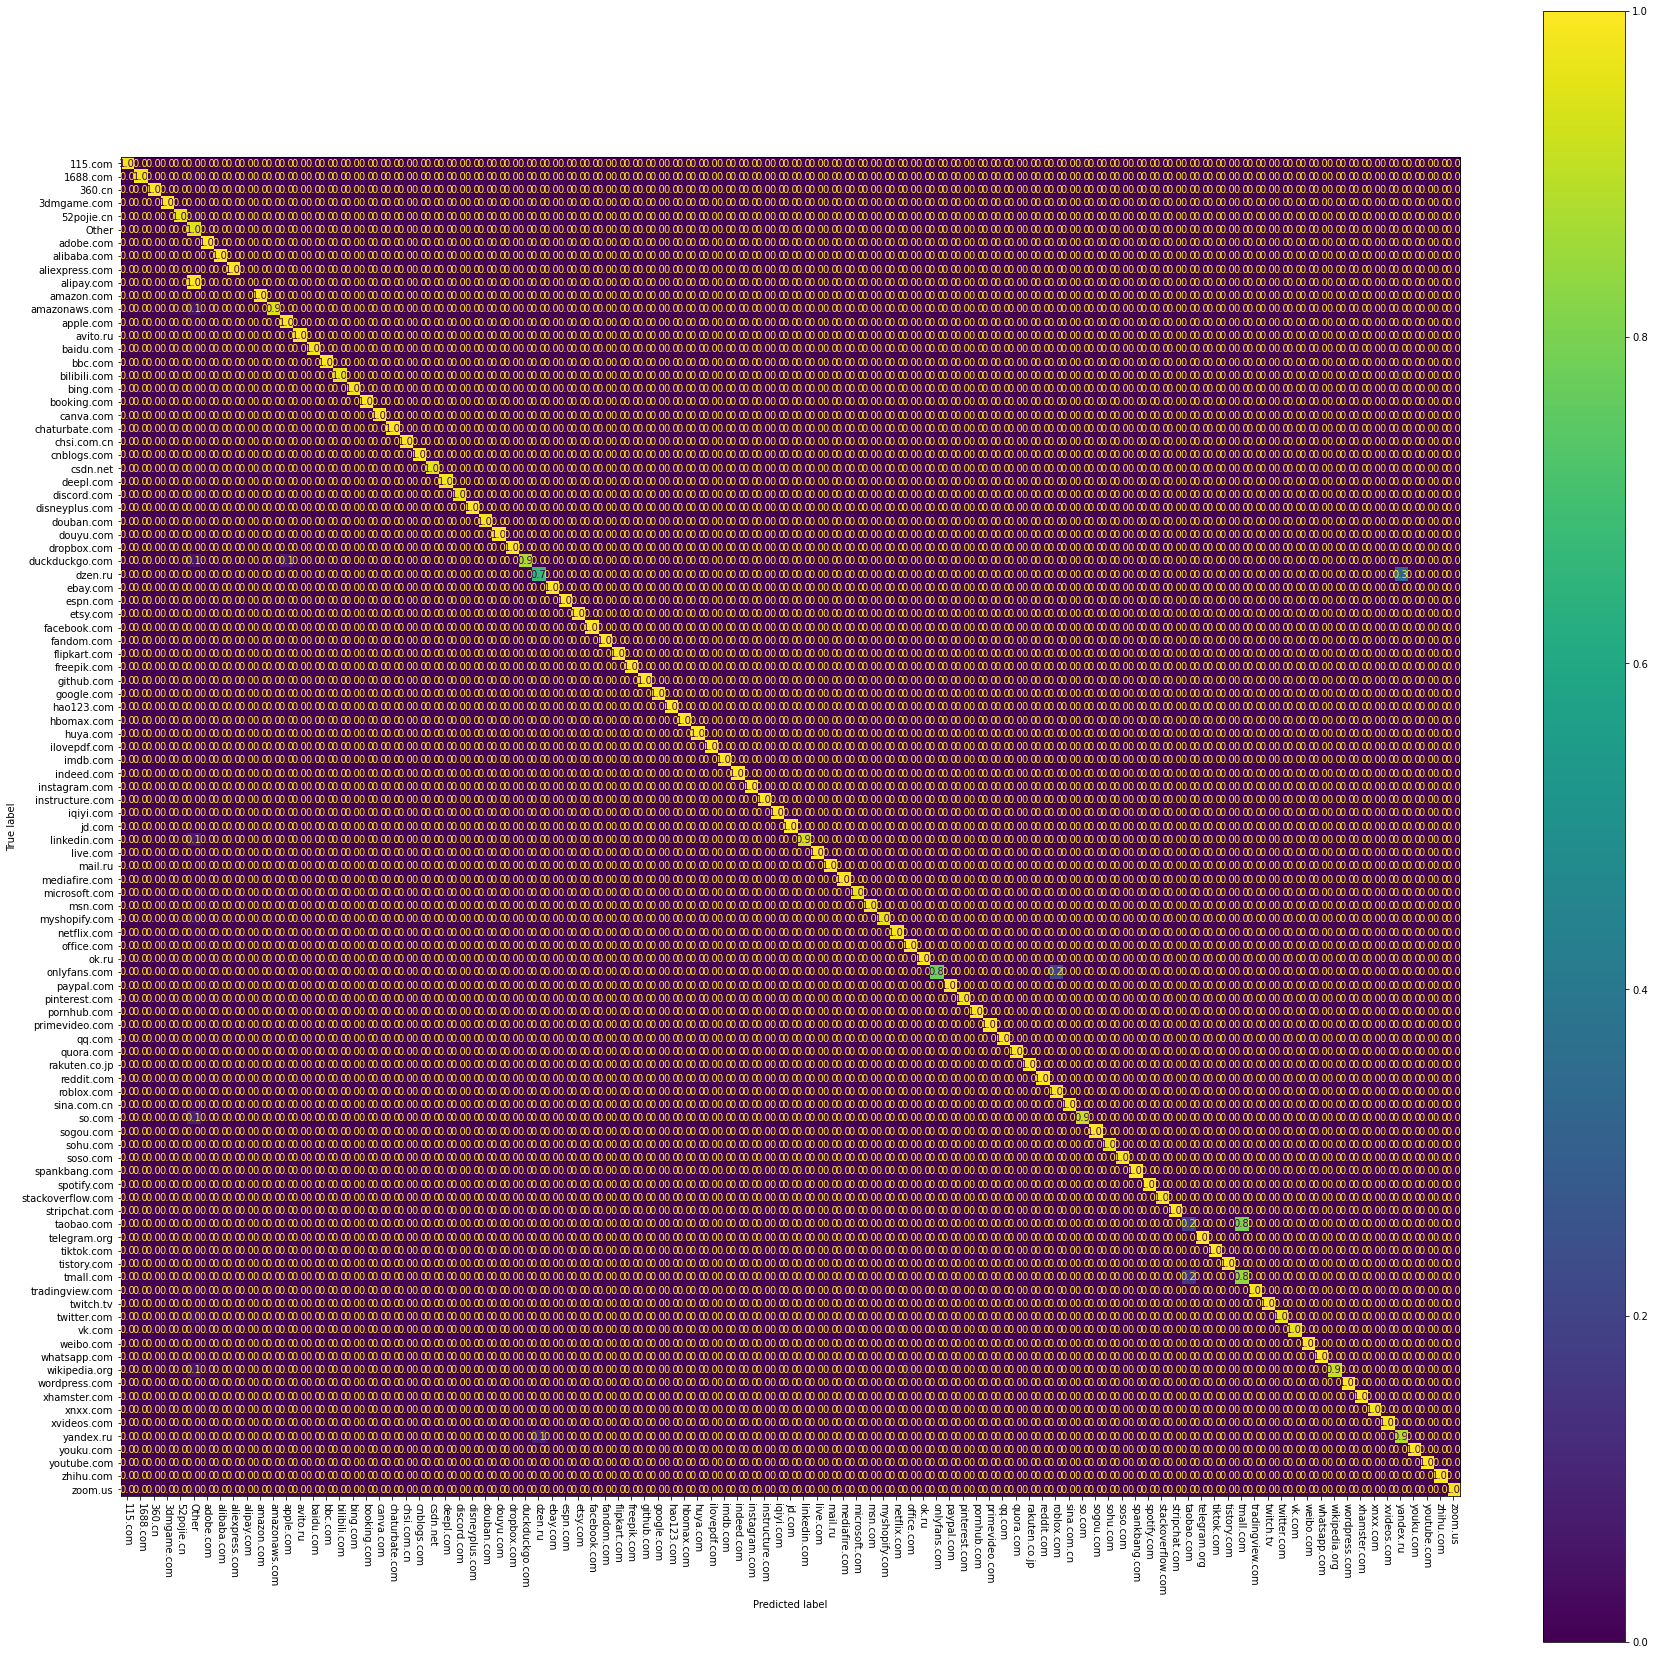

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.96      0.98      0.97        50
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        50
           4       1.00      0.97      0.98        58
           5       0.96      0.95      0.96      2820
           6       1.00      1.00      1.00        53
           7       1.00      1.00      1.00        58
           8       0.97      1.00      0.98        56
           9       0.00      0.00      0.00        59
          10       0.97      1.00      0.98        60
          11       0.77      0.95      0.85        57
          12       0.94      0.99      0.96        67
          13       0.98      1.00      0.99        54
          14       1.00      0.98      0.99        63
          15       1.00      1.00      1.00        59
          16       0.96      0.96      0.96        56
          17       0.94    

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [55]:
plot_results(model, vpn_features_test, vpn_labels_test)

ValueError: The number of FixedLocator locations (67), usually from a call to set_ticks, does not match the number of ticklabels (101).

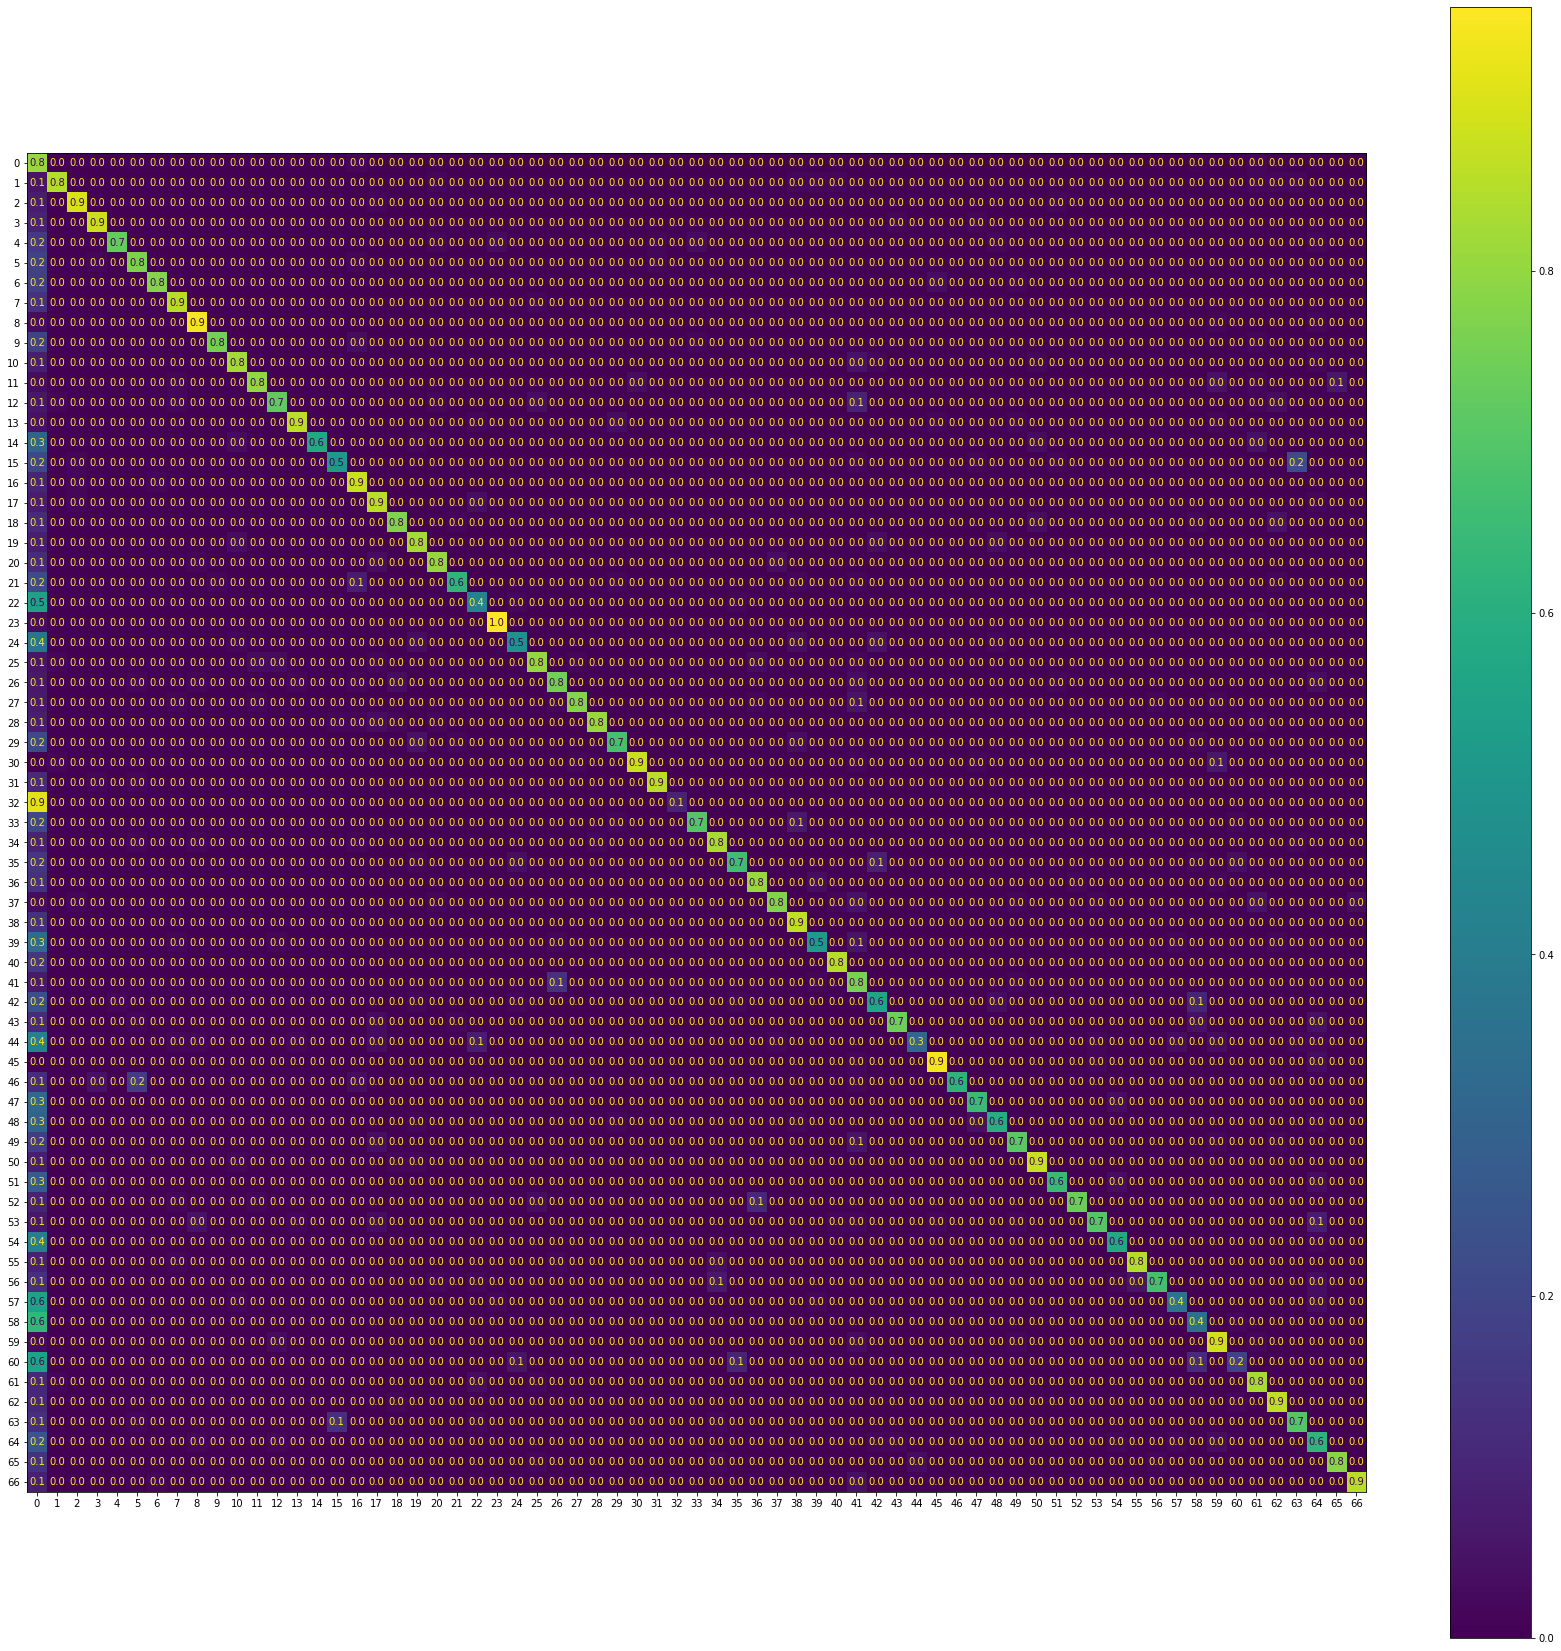

In [58]:
plot_results(model, tor_features_test, tor_labels_test)

In [68]:

y_true = np.argmax(tor_labels_test, axis=1)
predictions =  np.argmax(model.predict(tor_features_test), axis=1)
cm = confusion_matrix(y_true, predictions, normalize='true')
print(classification_report(y_true, predictions))


              precision    recall  f1-score   support

           5       0.74      0.81      0.77      2713
           6       0.91      0.85      0.88        71
           7       0.83      0.90      0.86        67
           8       0.85      0.88      0.87        66
          10       0.94      0.73      0.82        70
          13       0.61      0.77      0.68        60
          15       0.74      0.78      0.76        67
          17       0.77      0.85      0.81        67
          18       0.78      0.94      0.85        66
          19       0.89      0.75      0.82        65
          24       0.76      0.82      0.79        62
          25       0.88      0.80      0.84        65
          26       0.80      0.72      0.76        65
          29       0.90      0.86      0.88        64
          30       0.91      0.58      0.71        69
          31       0.73      0.51      0.60        68
          32       0.50      0.88      0.64        72
          33       0.60    

In [84]:
# Get the unique class labels present in both y_true and predictions
unique_labels = np.unique(np.concatenate((np.unique(y_true), np.unique(predictions))))

# Compute the confusion matrix
cm = confusion_matrix(y_true, predictions, normalize='true')

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[label_binariser.classes_[x] for x in tor_unique_y]
    )




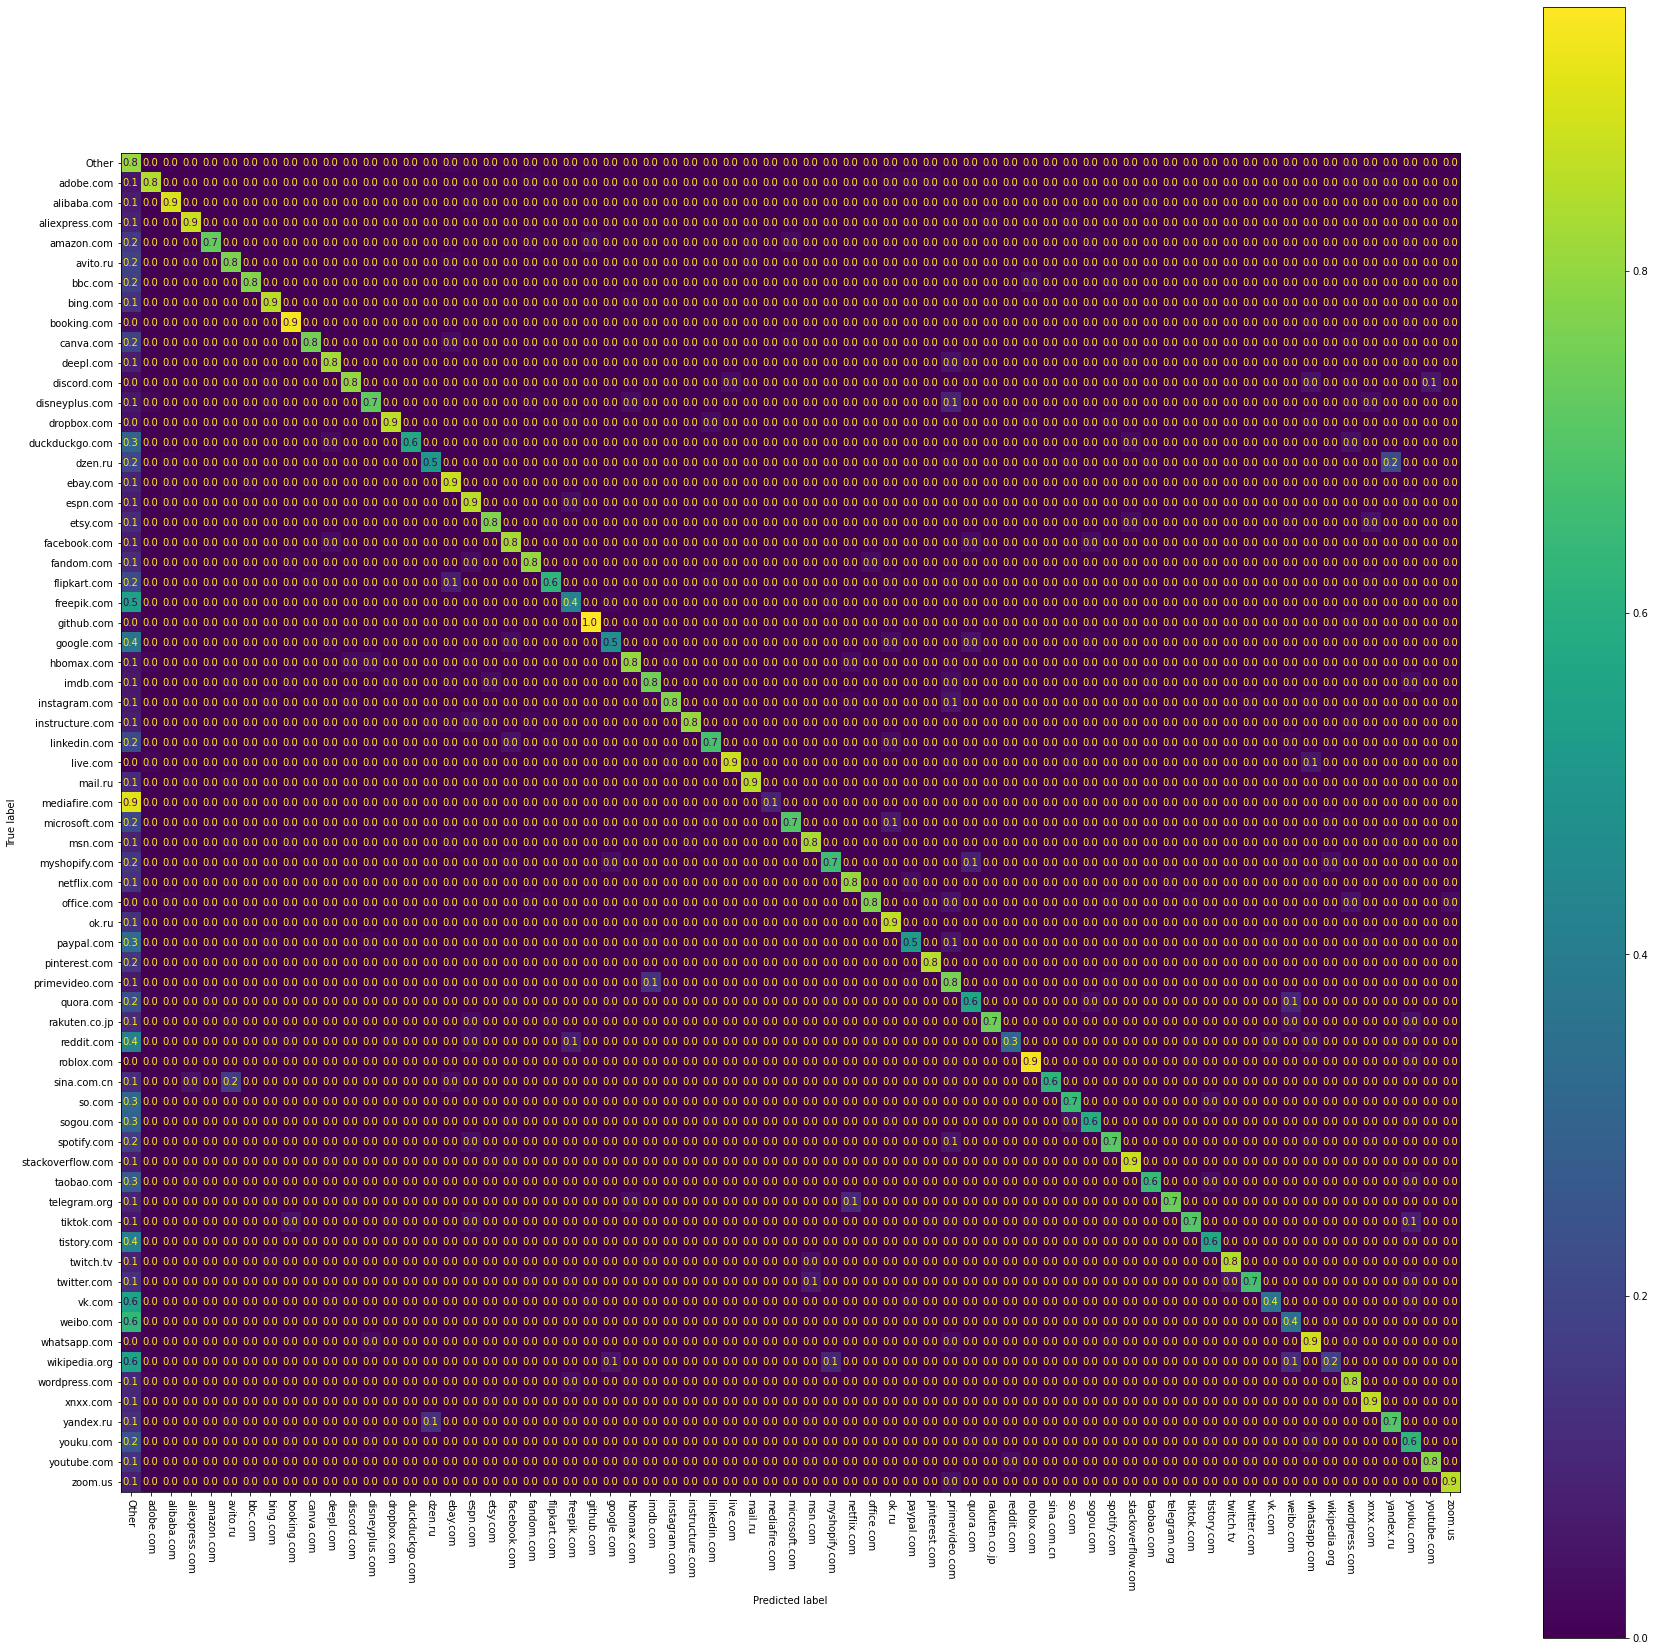

In [85]:
fig, ax = plt.subplots(figsize=(30, 30))
disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
plt.show()